In [157]:
import scipy.linalg
import scipy.optimize
import sys
import numpy as np
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_function as tfu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.theodolite_utils as ttfu


def resection_with_2_known_points(point1, point2, measures_first_point, measures_second_point):
    station_z = ((point1[2] - measures_first_point[2]*np.cos(measures_first_point[0])) + (point2[2] - measures_second_point[2]*np.cos(measures_second_point[0])))/2
    
    # find the position of the total station using the intersection of 2 circles given by the measurements of the prism position.
    radius_1 = abs(measures_first_point[2]*np.sin(measures_first_point[0]))
    radius_2 = abs(measures_second_point[2]*np.sin(measures_second_point[0]))
    
    delta_x = point2[0] - point1[0]
    delta_y = point2[1] - point1[1]
    
    # find the y value based on the intersection of 2 circles aligned in x (same value of x)
    y = (np.power(radius_1, 2) - np.power(radius_2, 2) - np.power(point1[1], 2) + np.power(point2[1], 2))/(2*delta_y)
    
    # find the possible values of x based on the quadratic formula and the circle formula knowing y
    A = 1
    B = -2*point1[0]
    C = np.power(point1[0], 2) + np.power(y, 2) + np.power(point1[1], 2) - 2*y*point1[1] - np.power(radius_1, 2)
    
    x_1 = (-B + np.sqrt(np.power(B, 2) - 4*A*C))/2*A
    
    x_2 = (-B - np.sqrt(np.power(B, 2) - 4*A*C))/2*A    
    
    # find the yaw offset to get the measures back in the prism's frame
    theta_station__prism_1 = np.arccos(abs(point1[0]-x_1)/radius_1)
    yaw_1 =  (measures_first_point[1] - theta_station__prism_1)
        
    theta_station__prism_2 = np.arccos(abs(point1[0]-x_2)/radius_2)
    yaw_2 =  (measures_first_point[1] - theta_station__prism_2)
        
    station_pos_complete_1 = np.array([x_1, y, station_z, 0, 0, 0]) #yaw_1])    
    station_pos_complete_2 = np.array([x_2, y, station_z, 0, 0, 0]) #yaw_2])
    
    return station_pos_complete_1, station_pos_complete_2

def calculate_tf_angle(point1, ref_point, station_pose):
    T = np.identity(4)
    dx1 = point1[0] - station_pose[0]
    dy1 = point1[1] - station_pose[1]
    dxref = ref_point[0] - station_pose[0]
    dyref = ref_point[1] - station_pose[1]
    if dx1 <= 0:
        if dy1 >= 0:
            theta1 = np.arctan2(dy1, abs(dx1))
            theta2 = np.arctan2(dyref, dxref)
            thetaR = -(np.pi - theta1 - theta2)
        else:
            theta1 = np.arctan2(abs(dy1), abs(dx1))
            theta2 = np.arctan2(dyref, dxref)
            thetaR = -(np.pi + theta1 - theta2)
    else:
        if dy1 >= 0:
            theta1 = np.arctan2(dy1, dx1)
            theta2 = np.arctan2(dyref, dxref)
            thetaR = -(theta1 - theta2)
        else:
            theta1 = np.arctan2(abs(dy1), dx1)
            theta2 = np.arctan2(dyref, dxref)
            thetaR = -(theta2 + theta1)
    Rot_r = np.array([[np.cos(thetaR), -np.sin(thetaR), 0],
                 [np.sin(thetaR), np.cos(thetaR), 0],
                 [0, 0, 1]])
    T[0:3,0:3]=Rot_r
    return T

In [158]:
%matplotlib notebook

pilier_A = np.array([1000, 1000, 100])
pilier_B = np.array([1000, 1000 + np.sqrt(np.power(181.016, 2) + np.power(0.323, 2)), 100 + 0.323])
pilier_C = np.array([1000, 1000 + np.sqrt(np.power(363.492, 2) + np.power(1.038, 2)), 100 + 1.038])
pilier_D = np.array([1000, 1000 + np.sqrt(np.power(548.578, 2) + np.power(2.374, 2)), 100 + 2.374])

# Read markers file of grand axe and show them
tfu = importlib.reload(tfu)
ttfu = importlib.reload(ttfu)

file_name = './data/total_station/20220630-1/theodolite_reference_prisms.txt'

raw_1, raw_2, raw_3, trimble_1, trimble_2, trimble_3, T_1_grand, T_2_grand, T_3_grand = ttfu.read_marker_file_raw_data(file_name)

station_1_pos1, station_1_pos2 = resection_with_2_known_points(pilier_D, pilier_C, raw_1[0], raw_1[1])

station_2_pos1, station_2_pos2 = resection_with_2_known_points(pilier_D, pilier_C, raw_2[0], raw_2[1])

station_3_pos1, station_3_pos2 = resection_with_2_known_points(pilier_D, pilier_C, raw_3[0], raw_3[1])
print("Sation 1:")
print("possible position 1: ", station_1_pos1)
print("possible position 2: ", station_1_pos2)
print("Station 2:")
print("possible position 1: ", station_2_pos1)
print("possible position 2: ", station_2_pos2)
print("Station 3:")
print("possible position 1: ", station_3_pos1)
print("possible position 2: ", station_3_pos2)

Sation 1:
possible position 1:  [1015.07248495 1425.66233548  100.75719957    0.            0.
    0.        ]
possible position 2:  [ 984.92751505 1425.66233548  100.75719957    0.            0.
    0.        ]
Station 2:
possible position 1:  [1014.27187431 1426.29717828  101.05921333    0.            0.
    0.        ]
possible position 2:  [ 985.72812569 1426.29717828  101.05921333    0.            0.
    0.        ]
Station 3:
possible position 1:  [1013.48523852 1427.43492717  101.31934496    0.            0.
    0.        ]
possible position 2:  [ 986.51476148 1427.43492717  101.31934496    0.            0.
    0.        ]


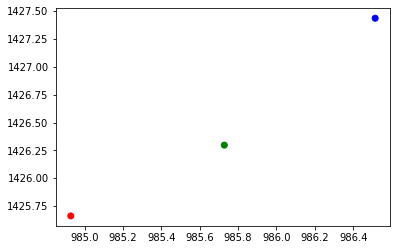

In [159]:
%matplotlib inline
plt.figure()
plt.scatter([station_1_pos2[0], station_2_pos2[0], station_3_pos2[0]],[station_1_pos2[1], station_2_pos2[1], station_3_pos2[1]],c=['r', 'g', 'b'])

Average error during the calibration:  8.548 mm
TF1:  [[-6.53265171e-02  9.97863942e-01  0.00000000e+00  9.84927515e+02]
 [-9.97863942e-01 -6.53265171e-02  0.00000000e+00  1.42566234e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00757200e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
TF2:  [[ 5.61832014e-01 -8.27251345e-01  0.00000000e+00  9.85728126e+02]
 [ 8.27251345e-01  5.61832014e-01  0.00000000e+00  1.42629718e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.01059213e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
TF3:  [[ 8.33107179e-01  5.53111588e-01  0.00000000e+00  9.86514761e+02]
 [-5.53111588e-01  8.33107179e-01  0.00000000e+00  1.42743493e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.01319345e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


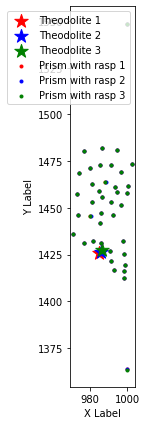

In [160]:
%matplotlib inline

tfu = importlib.reload(tfu)
# choose which line is right for each total station in this section (the correct position is the first or the 2nd found with the resection)
#TF1 = tfu.tf_from_pose_roll_pitch_yaw(station_1_pos1)
TF1 = ttfu.tf_from_pose_roll_pitch_yaw(station_1_pos2)

#TF2 = tfu.tf_from_pose_roll_pitch_yaw(station_2_pos1)
TF2 = ttfu.tf_from_pose_roll_pitch_yaw(station_2_pos2)

#TF3 = tfu.tf_from_pose_roll_pitch_yaw(station_3_pos1)
TF3 = ttfu.tf_from_pose_roll_pitch_yaw(station_3_pos2)

tp1 = TF1@trimble_1
tp2 = TF2@trimble_2
tp3 = TF3@trimble_3
tp1 = tp1.T
tp2 = tp2.T
tp3 = tp3.T

TR1 = calculate_tf_angle(tp1[0], pilier_D, TF1[0:3,3])
TF1 = TF1@TR1
tp1 = TF1@trimble_1
tp1=tp1.T

TR2 = calculate_tf_angle(tp2[0], pilier_D, TF2[0:3,3])
TF2 = TF2@TR2
tp2 = TF2@trimble_2
tp2=tp2.T

TR3 = calculate_tf_angle(tp3[0], pilier_D, TF3[0:3,3])
TF3 = TF3@TR3
tp3 = TF3@trimble_3
tp3=tp3.T

error = []
for i,j,k in zip(tp1,tp2,tp3):
    dist_12 = np.linalg.norm(i-j)
    dist_13 = np.linalg.norm(i-k)
    dist_23 = np.linalg.norm(k-j)
    error.append(dist_12)
    error.append(dist_13)
    error.append(dist_23)
print("Average error during the calibration: ", round(np.mean(error)*1000,3), "mm")
print("TF1: ", TF1)
print("TF2: ", TF2)
print("TF3: ", TF3)

tfu.plot_trajectories_prism(3, tp1.T, tp2.T, tp3.T, TF1, TF2, TF3, 0, 0,"example.pdf",1)

In [161]:
print(tp1[0])
print(tp2[0])
print(tp3[0])

[1.00000122e+03 1.54859306e+03 1.02374336e+02 1.00000000e+00]
[1.00000116e+03 1.54859307e+03 1.02375028e+02 1.00000000e+00]
[1.00000111e+03 1.54859308e+03 1.02374633e+02 1.00000000e+00]


In [163]:
print(np.linalg.norm(tp1[0]-tp1[1]))

185.08665954124587
